In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

df_confirmed = pd.read_csv(
    '../../corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
                sep=',',encoding='ISO8859-1')

df_deceased = pd.read_csv(
    '../../corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
                sep=',',encoding='ISO8859-1')


In [18]:
df_confirmed.head(40)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,16,21,22,22,22,24,24,40,40,74
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,42,51,55,59,64,70,76,89,104,123
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,48,54,60,74,87,90,139,201,230,264
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,1,2,39,39,53,75,88,113,133,164
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,0,0,1,2,2,3,3
5,NaN,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,3,3
6,NaN,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,...,45,56,68,79,97,128,158,266,301,387
7,NaN,Armenia,40.0691,45.0382,0,0,0,0,0,0,...,26,52,78,84,115,136,160,194,235,249
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,...,1,2,2,3,4,6,9,19,32,39
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,134,171,210,267,307,353,436,669,669,818


In [19]:
countries = df_confirmed['Country/Region'].unique()
sorted(countries)

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guyana',
 'Haiti',
 'Holy See',
 'Honduras',
 'Hungary',
 'Iceland',
 'In

In [20]:

all_countries = pd.DataFrame()

for c in countries:
    temp = df_confirmed[df_confirmed['Country/Region'] == c]
    temp = temp.groupby('Country/Region')
    temp = temp.sum().iloc[:,4:]
    temp = temp.T

    all_countries = pd.concat([all_countries,temp],axis=1)

def create_country_df(country):
    
    confirmed = all_countries[country]
    confirmed.index = pd.to_datetime(confirmed.index)
    factor = confirmed / confirmed.shift()
    data = pd.concat([confirmed,factor],axis=1)
    data.columns = ['confirmed','factor']
    data.factor.replace(np.inf,np.nan,inplace=True)
    data['inc'] = data['confirmed'] - data['confirmed'].shift()
    return data

confirmed_dict = dict()

for c in countries:
    confirmed_dict[c] = create_country_df(c)
    
thai = confirmed_dict['Thailand']
swe = confirmed_dict['Sweden']
ita = confirmed_dict['Italy']
korea = confirmed_dict['Korea, South']
us = confirmed_dict['US']
spain = confirmed_dict['Spain']
ger = confirmed_dict['Germany']

ger


,confirmed,factor,inc
2020-01-24,0,NaN,NaN
2020-01-25,0,NaN,0.0
2020-01-26,0,NaN,0.0
2020-01-27,1,NaN,1.0
2020-01-28,4,4.000000,3.0
...,...,...,...
2020-03-20,19848,1.295561,4528.0
2020-03-21,22213,1.119156,2365.0
2020-03-22,24873,1.119750,2660.0
2020-03-23,29056,1.168174,4183.0


In [21]:
global_confirmed = df_confirmed.iloc[:,5:].sum()


In [22]:
global_deceased = df_deceased.iloc[:,5:].sum()
global_deceased.index = pd.to_datetime(global_deceased.index)
global_confirmed = df_confirmed.iloc[:,5:].sum()
global_confirmed.index = pd.to_datetime(global_confirmed.index)

global_data = pd.DataFrame(global_confirmed,columns=['confirmed'])
global_data['factor'] = global_data['confirmed'] / global_data['confirmed'].shift()
global_data['inc'] = global_data['confirmed'] - global_data['confirmed'].shift()
global_data['dead'] = global_deceased
global_data['dead_factor'] = global_data['dead'] / global_data['dead'].shift()
global_data['dead_inc'] = global_data['dead'] - global_data['dead'].shift()
global_data['pct_dead'] = 100 * global_data['dead'] /global_data['confirmed']
global_data.index = pd.to_datetime(global_data.index)
global_data.to_pickle('global_data.pkl')
global_data
global_data.describe()

,confirmed,factor,inc,dead,dead_factor,dead_inc,pct_dead
count,62.000000,61.000000,61.000000,62.000000,61.000000,61.000000,62.000000
mean,96680.838710,1.121109,6852.852459,3505.887097,1.127463,305.032787,3.058677
std,92239.012878,0.161101,10092.960986,4097.952328,0.134968,495.138128,0.713496
min,654.000000,1.004913,287.000000,18.000000,1.001780,2.000000,2.040890
25%,35073.250000,1.025635,1693.000000,740.750000,1.030049,62.000000,2.380055
50%,78765.000000,1.072708,2612.000000,2463.500000,1.098717,100.000000,3.127660
75%,112629.500000,1.122988,5031.000000,3941.500000,1.144915,244.000000,3.499220
max,418678.000000,1.905706,41458.000000,18625.000000,1.615385,2120.000000,4.448526


/usr/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


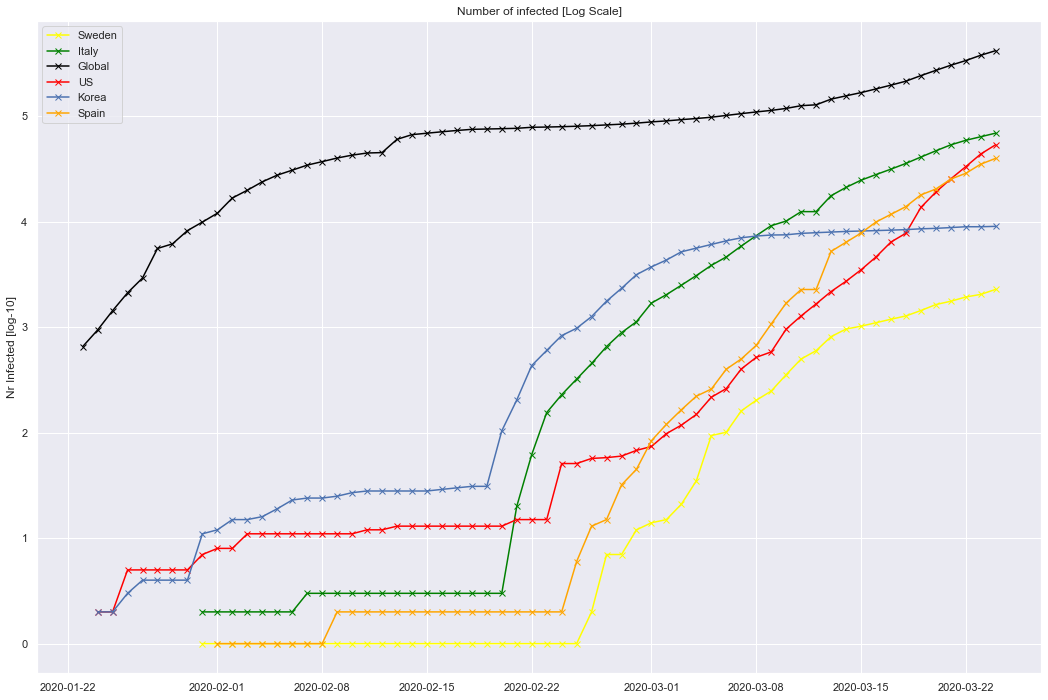

In [23]:
global_conf = np.log10(global_confirmed)

swe_conf = swe.loc[swe['confirmed'] > 0]
swe_conf = np.log10(swe_conf['confirmed'])
ita_conf = ita.loc[ita['confirmed'] > 0]
ita_conf = np.log10(ita_conf['confirmed'])
us_conf = us.loc[us['confirmed'] > 0]
us_conf = np.log10(us_conf['confirmed'])
korea_conf = korea.loc[korea['confirmed'] > 0]
korea_conf = np.log10(korea_conf['confirmed'])
spain_conf = spain.loc[spain['confirmed'] > 0]
spain_conf = np.log10(spain['confirmed'])

plt.figure(figsize=(18,12))
plt.title('Number of infected [Log Scale]')
plt.plot(swe_conf,'x-',color='yellow',label='Sweden')
plt.plot(ita_conf,'x-',color='green',label='Italy')
plt.plot(global_conf,'x-',color='black',label='Global')
plt.plot(us_conf,'x-',color='red',label='US')
plt.plot(korea_conf,'x-',color='b',label='Korea')
plt.plot(spain_conf,'x-',color='orange',label='Spain')
plt.ylabel('Nr Infected [log-10]')
plt.legend(loc='upper left')
plt.savefig('corona_evolution_countries_log.jpg',format='jpg')

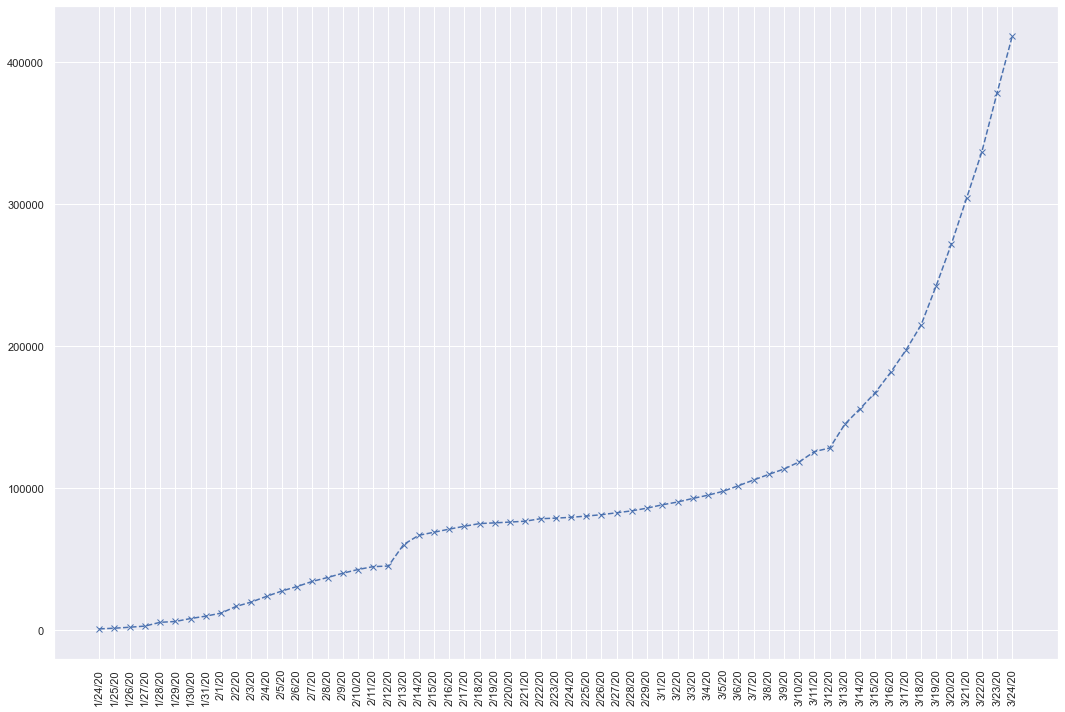

In [24]:
global_series = all_countries.sum(axis=1)
_= plt.figure(figsize=(18,12))
_= plt.plot(global_series,'x--')

_= plt.xticks(rotation=90)



In [25]:


countries_deceased = countries
all_countries_deceased = pd.DataFrame()

for c in countries_deceased:
    temp = df_deceased[df_deceased['Country/Region'] == c]
    temp = temp.groupby('Country/Region')
    temp = temp.sum().iloc[:,4:]
    temp = temp.T

    all_countries_deceased = pd.concat([all_countries_deceased,temp],axis=1)
    

def create_deceased_df(country):
    process = True
    try:
        deceased = all_countries_deceased[country]
    except KeyError:
        print ('cant find {} in deaths'.format(country))
        process = False
        
    if process:
        deceased.index = pd.to_datetime(deceased.index)
        factor = deceased / deceased.shift()

        data = pd.concat([deceased,factor],axis=1)
        data.columns = ['deceased','dead_factor']
        data.dead_factor.replace(np.inf,np.nan,inplace=True)
        data['dead_inc'] = data['deceased'] - data['deceased'].shift()
        return data

deceased_dict = dict()

for c in countries_deceased:
    
    deceased_dict[c] = create_deceased_df(c)




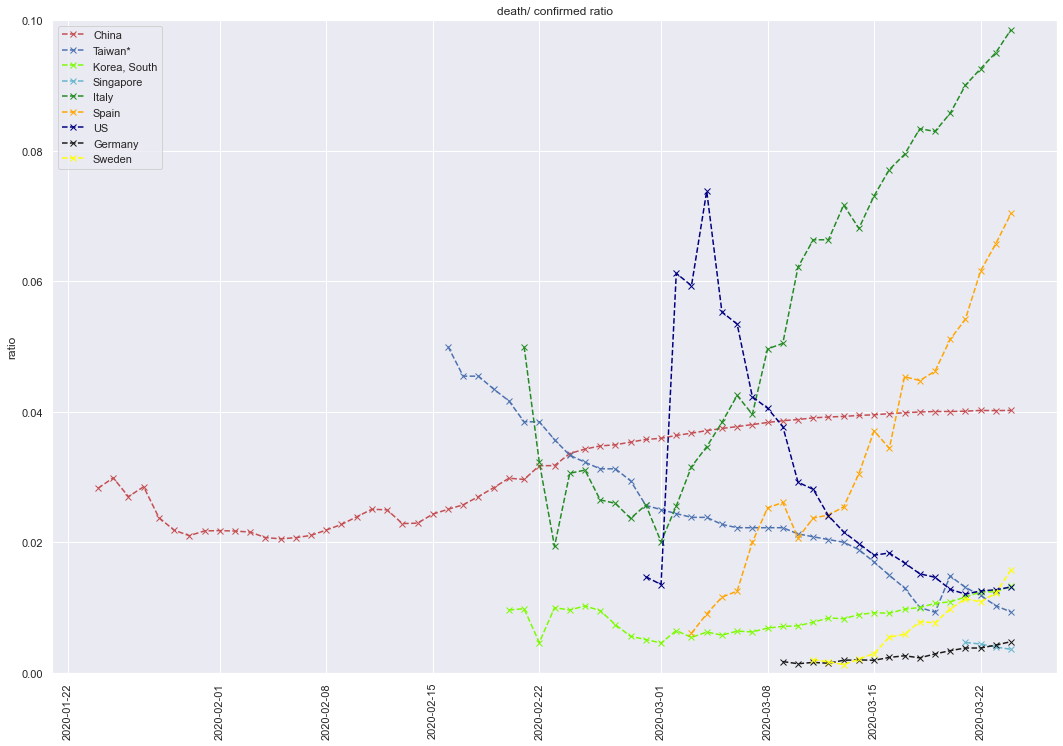

In [26]:
country_data = dict()

for c in countries:
    country_data[c] = pd.concat([confirmed_dict[c],deceased_dict[c]],axis=1)
    country_data[c]['pct_dead'] = 100 * country_data[c]['deceased'] / country_data[c]['confirmed']
    country_data[c]['conf_over_dead'] = country_data[c]['confirmed'] / country_data[c]['deceased']
    country_data[c]['conf_over_dead'] = country_data[c]['conf_over_dead'].replace(np.inf,np.nan)
    country_data[c]['dead_conf_ratio'] =  country_data[c]['dead_factor'] / country_data[c]['factor']
    

import pickle

with open ('country_data.pkl','wb') as f:
    pickle.dump(country_data,f,protocol=pickle.HIGHEST_PROTOCOL)

countries_of_interest = ['China','Taiwan*','Korea, South','Singapore',
                         'Italy','Spain','US','Germany','Sweden']

colors = ['r','b','lawngreen','c',
          'forestgreen','orange','navy','k','yellow']

plt.figure(figsize=(18,12))
plt.title('death/ confirmed ratio')

i = 0
for c in countries_of_interest:
    country = country_data[c]
    mask = country['deceased'] >= 1
    country = country[mask]
    plt.plot(country['deceased'] / country['confirmed'],'x--',
             color=colors[i],label=c)
    i += 1      

plt.ylabel('ratio')
plt.xticks(rotation=90)
plt.ylim([0,0.10])
plt.legend(loc='upper left')
#plt.yscale('log')

plt.savefig('corona_dead_conf_ratio.jpg',format='jpg')


In [27]:
country_data['Sweden']

,confirmed,factor,inc,deceased,dead_factor,dead_inc,pct_dead,conf_over_dead,dead_conf_ratio
2020-01-24,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2020-01-25,0,NaN,0.0,0,NaN,0.0,NaN,NaN,NaN
2020-01-26,0,NaN,0.0,0,NaN,0.0,NaN,NaN,NaN
2020-01-27,0,NaN,0.0,0,NaN,0.0,NaN,NaN,NaN
2020-01-28,0,NaN,0.0,0,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2020-03-20,1639,1.138985,200.0,16,1.454545,5.0,0.976205,102.437500,1.277054
2020-03-21,1763,1.075656,124.0,20,1.250000,4.0,1.134430,88.150000,1.162082
2020-03-22,1934,1.096994,171.0,21,1.050000,1.0,1.085832,92.095238,0.957161
2020-03-23,2046,1.057911,112.0,25,1.190476,4.0,1.221896,81.840000,1.125308


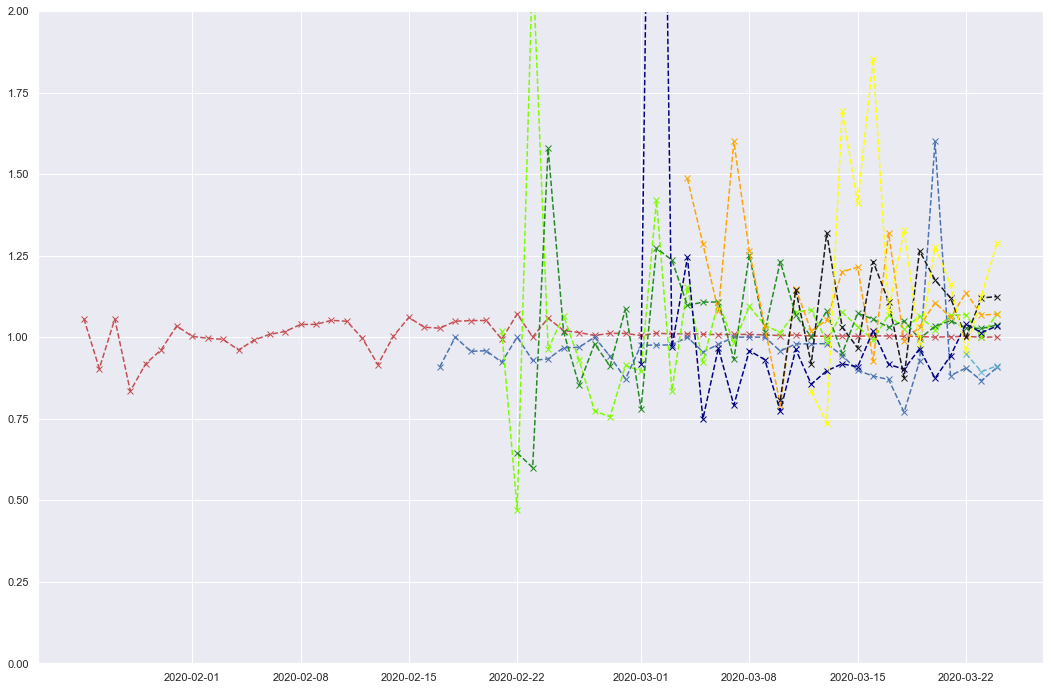

In [28]:
plt.figure(figsize=(18,12))
plt.ylim([0,2])
i = 0
for c in countries_of_interest:
    country = country_data[c]
    mask = country['deceased'] >= 1
    country = country[mask]
    plt.plot(country['dead_conf_ratio'],'x--',
             color=colors[i],label=c)
    i += 1 